## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [79]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from plotnine import *

In [61]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1')
df.head()

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease


In [62]:

df['diagnosis'] = np.where(df['diagnosis'] == 'No Disease', 0, 1)
df.head()


,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,0
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,1
2,Miles Wolf,62,0,3,130,263,1,97,0
3,Mikaila Block,43,1,1,115,303,1,181,1
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,1


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [84]:
# Split features and target variable
X = df[['age', 'chol']]
y = df['diagnosis']

ct = ColumnTransformer(
    [
    ("standardize", StandardScaler(), ['age', 'chol'])
    ],
    remainder="drop"
)

# Define the pipeline
logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression())]
)

params = {'logreg__C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(logreg_pipeline, params, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X, y)
grid_search.best_params_['logreg__C']

0.01

In [85]:
# Define the final pipeline
final_logreg_pipeline = Pipeline([
    ("preprocessor", ct),
    ("logreg", LogisticRegression(C=0.01))]
)

final_logreg_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'chol'])])),
                ('logreg', LogisticRegression(C=0.01))])

In [86]:
age = 55
max = df['chol'].max()
min = df['chol'].min()
cholesterol = np.arange(min, 3000, 20)

df_predict = pd.DataFrame({
    'age': age,
    'chol': cholesterol
})

df_predict['heart_disease_prob'] = final_logreg_pipeline.predict_proba(df_predict)[:, 0] # Predict probability of NOT having heart disease
df_predict.head()

,age,chol,heart_disease_prob
0,55,126,0.409332
1,55,146,0.414351
2,55,166,0.419389
3,55,186,0.424443
4,55,206,0.429513


In [87]:
# Find cholesterol level for predicting heart disease (threshold = 0.5)
chol_50 = df_predict.loc[df_predict['heart_disease_prob'] >= 0.5, 'chol'].min()

print(f"Cholesterol level for predicting heart disease (threshold = 0.5): {chol_50}")

# Find cholesterol level for 90% chance of heart disease
chol_90 = df_predict.loc[df_predict['heart_disease_prob'] >= 0.9, 'chol'].min()

print(f"Cholesterol level for 90% chance of heart disease: {chol_90}")

Cholesterol level for predicting heart disease (threshold = 0.5): 486
Cholesterol level for 90% chance of heart disease: 2606


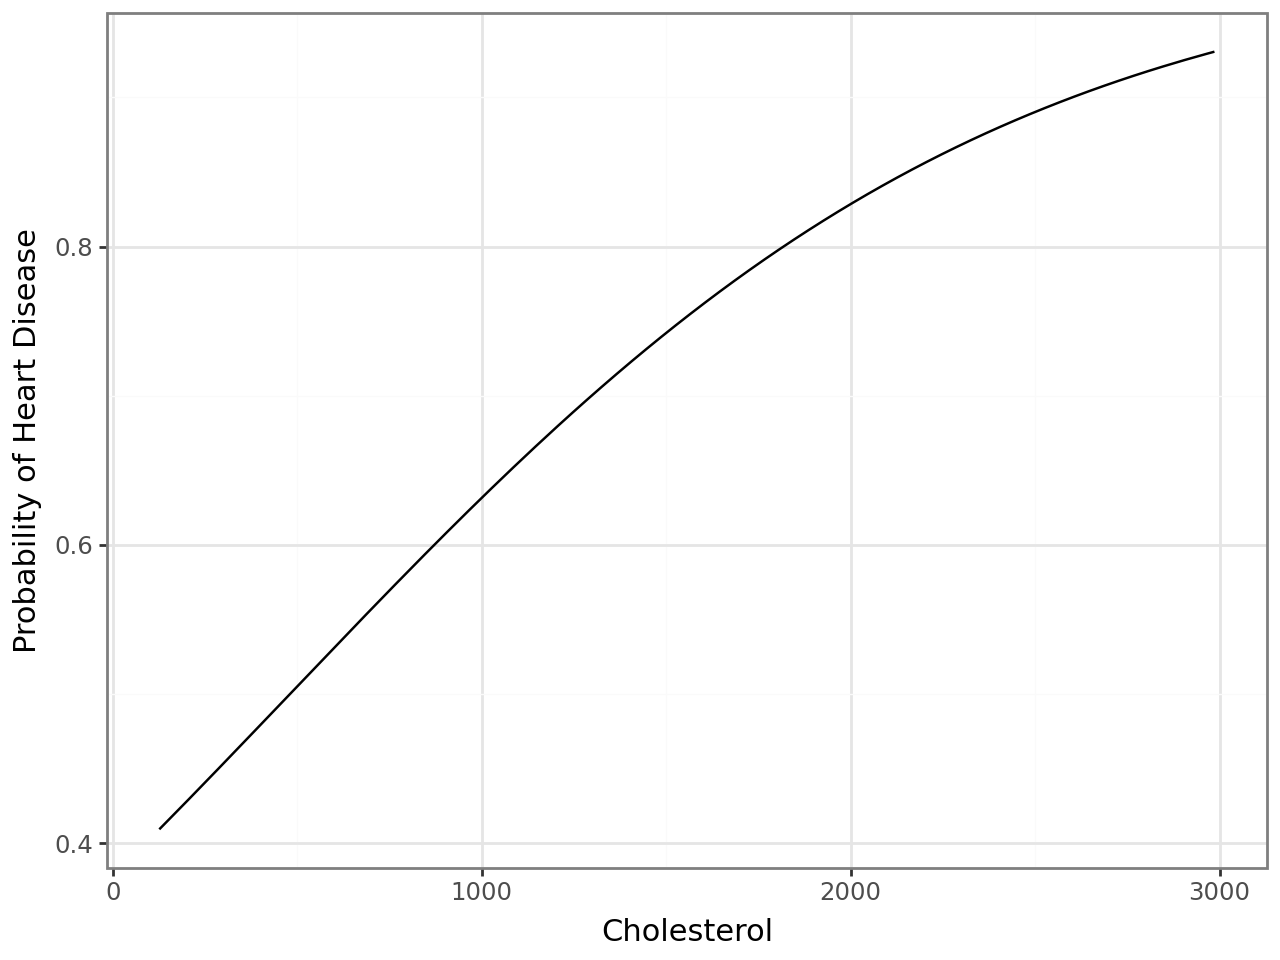

In [88]:
(ggplot(df_predict, aes(x='chol', y='heart_disease_prob')) +
  geom_line() +
  labs(x='Cholesterol', y='Probability of Heart Disease') +
  theme_bw()
)

A cholesterol level of 486 is required for a 55-year-old to have a 50% predicted probability of heart disease. Meanwhile, a cholesterol level of 2066 is required for a 55-year-old to have a 90% predicted probability of heart disease, which is physiolgically impossible. The curve from the plot shows the probability of heart disease increasing non-linearly with cholesterol level, as expected from logistic regression.

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [68]:
lda_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())]
).set_output(transform="pandas")

params = {'lda__solver': ['svd', 'lsqr', 'eigen'],
          "lda__n_components": [1]
          }

grid_search = GridSearchCV(
    lda_pipeline,
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'lda__n_components': 1, 'lda__solver': 'svd'}


In [69]:
final_lda_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis(n_components=1, solver='svd'))]
).set_output(transform="pandas")

final_lda_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'chol'])])),
                ('lda', LinearDiscriminantAnalysis(n_components=1))])

In [70]:
age = 55
max = df['chol'].max()
min = df['chol'].min()
cholesterol = np.arange(min, 3000, 20)

df_predict = pd.DataFrame({
    'age': age,
    'chol': cholesterol
})

df_predict['heart_disease_prob'] = final_lda_pipeline.predict_proba(df_predict)[:, 0] # Predict probability of NOT having heart disease
df_predict.head()

,age,chol,heart_disease_prob
0,55,126,0.393286
1,55,146,0.401859
2,55,166,0.410491
3,55,186,0.419180
4,55,206,0.427919


In [71]:
# Find cholesterol level for predicting heart disease (threshold = 0.5)
chol_50 = df_predict.loc[df_predict['heart_disease_prob'] >= 0.5, 'chol'].min()

print(f"Cholesterol level for predicting heart disease (threshold = 0.5): {chol_50}")

Cholesterol level for predicting heart disease (threshold = 0.5): 386


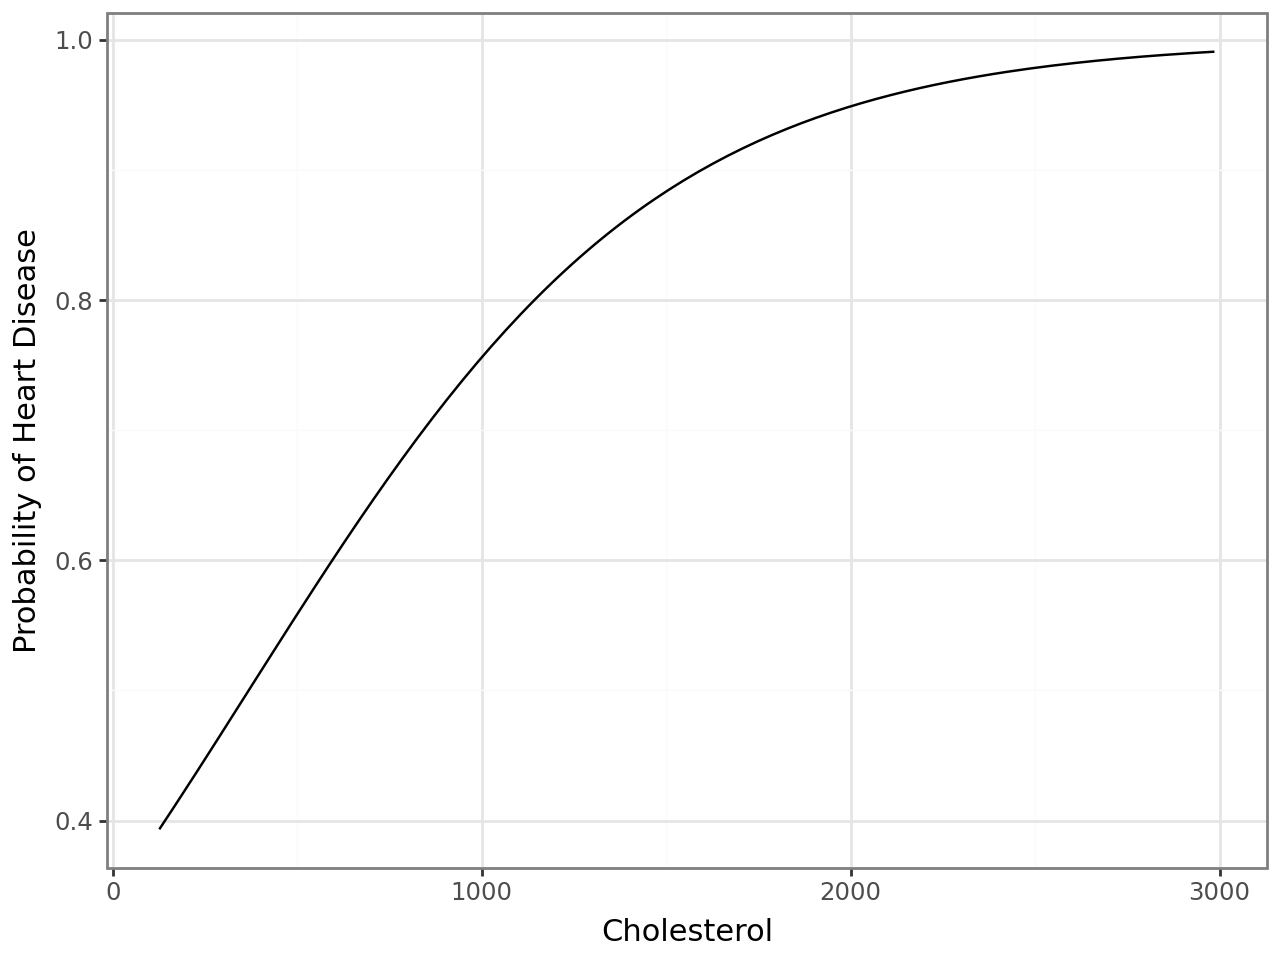

In [72]:
(ggplot(df_predict, aes(x='chol', y='heart_disease_prob')) +
  geom_line() +
  labs(x='Cholesterol', y='Probability of Heart Disease') +
  theme_bw()
)

With this model, a cholesterol level of 386 corresponds to a 50% probability of heart disease, which is lower than the previous model.

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [73]:
svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True, kernel="linear"))
    ]
).set_output(transform="pandas")

param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

svc_grid = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='roc_auc')

svc_grid.fit(X, y)
best_params = svc_grid.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'svc__C': 100}


In [75]:
final_svc_pipeline = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(probability=True, kernel="linear", C=100))]
).set_output(transform="pandas")

final_svc_pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standardize',
                                                  StandardScaler(),
                                                  ['age', 'chol'])])),
                ('svc', SVC(C=100, kernel='linear', probability=True))])

In [76]:
age = 55
max = df['chol'].max()
min = df['chol'].min()
cholesterol = np.arange(min, 3000, 20)

df_predict = pd.DataFrame({
    'age': age,
    'chol': cholesterol
})

df_predict['heart_disease_prob'] = final_svc_pipeline.predict_proba(df_predict)[:, 0] # Predict probability of NOT having heart disease
df_predict.head()

,age,chol,heart_disease_prob
0,55,126,0.408237
1,55,146,0.413333
2,55,166,0.418426
3,55,186,0.423519
4,55,206,0.428612


In [58]:
# Find cholesterol level for predicting heart disease (threshold = 0.5)
chol_50 = df_predict.loc[df_predict['heart_disease_prob'] >= 0.5, 'chol'].min()

print(f"Cholesterol level for predicting heart disease (threshold = 0.5): {chol_50}")

Cholesterol level for predicting heart disease (threshold = 0.5): 466


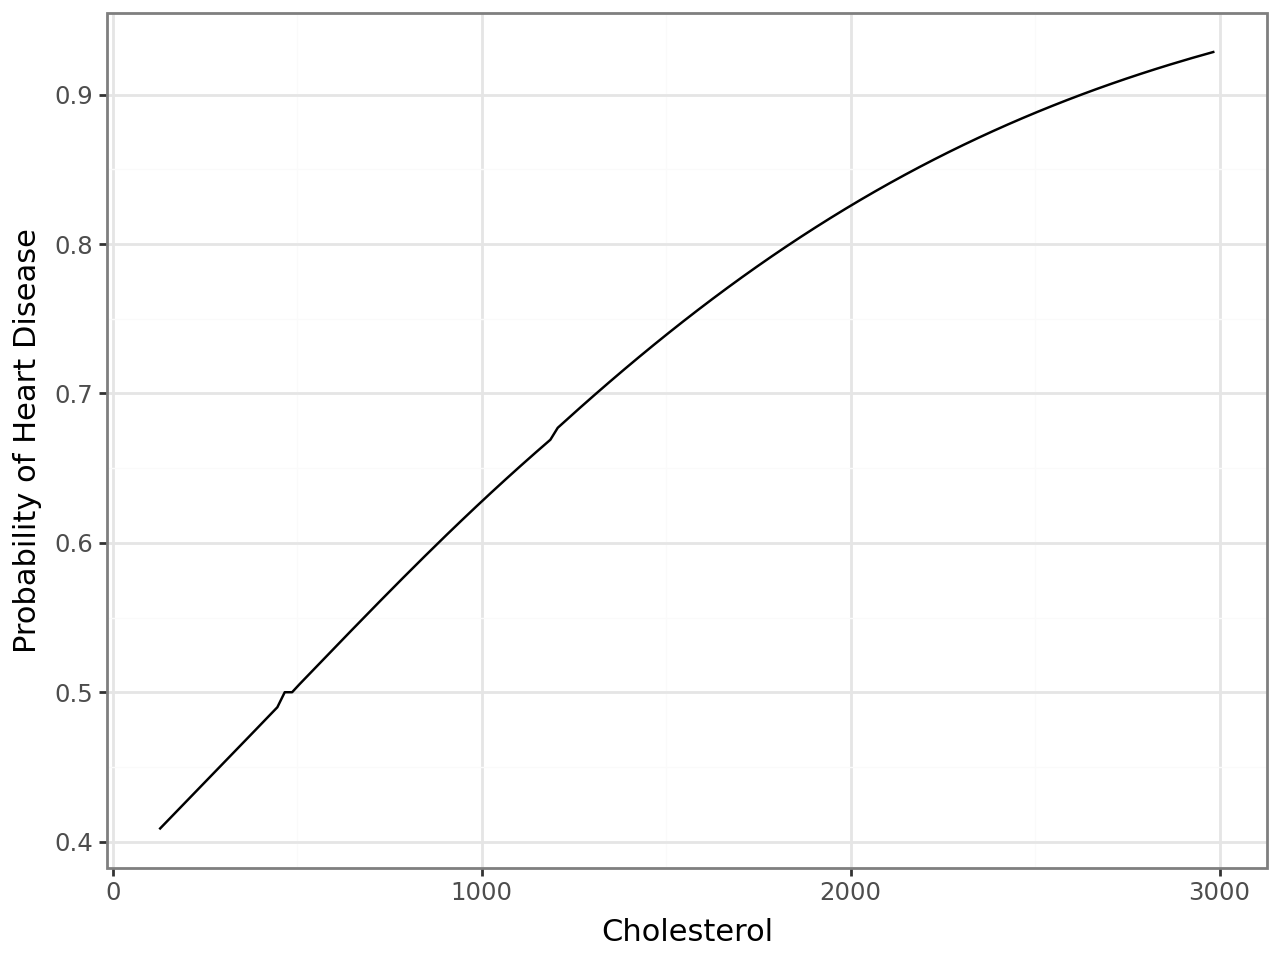

In [77]:
(ggplot(df_predict, aes(x='chol', y='heart_disease_prob')) +
  geom_line() +
  labs(x='Cholesterol', y='Probability of Heart Disease') +
  theme_bw()
)

With this model, a cholesterol level of 466 corresponds to a 50% probability of heart disease, which is consistent with the logistic regression model, which gave a threshold of 486 for 50% probability.

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [123]:
# Get coefficients
# Logistic Regression
logreg_model = final_logreg_pipeline.named_steps['logreg']
logreg_coef = logreg_model.coef_[0]  # Extract coefficients as a 1D array
logreg_intercept = logreg_model.intercept_[0]  # Extract intercept as a scalar

# LDA
lda_model = final_lda_pipeline.named_steps['lda']
lda_coef = lda_model.coef_[0]
lda_intercept = lda_model.intercept_[0]

# SVC
svc_model = final_svc_pipeline.named_steps['svc']
svc_coef = svc_model.coef_[0]
svc_intercept = svc_model.intercept_[0]


In [124]:
# Get scaling parameters
scaler = final_logreg_pipeline.named_steps['preprocessor'].named_transformers_['standardize']

# Means and standard deviations for age and chol
age_mean, age_std = scaler.mean_[0], scaler.scale_[0]
chol_mean, chol_std = scaler.mean_[1], scaler.scale_[1]

In [125]:
# Transform the coefficients and intercepts from the standardized scale to the original scale
# Logistic Regression
logreg_coef_original = logreg_model.coef_[0] / [age_std, chol_std]
logreg_intercept_original = (
    logreg_model.intercept_[0]
    - (logreg_model.coef_[0][0] * age_mean / age_std)
    - (logreg_model.coef_[0][1] * chol_mean / chol_std)
)

# LDA
lda_coef_original = lda_model.coef_[0] / [age_std, chol_std]
lda_intercept_original = (
    lda_model.intercept_[0]
    - (lda_model.coef_[0][0] * age_mean / age_std)
    - (lda_model.coef_[0][1] * chol_mean / chol_std)
)

# SVC
svc_coef_original = svc_model.coef_[0] / [age_std, chol_std]
svc_intercept_original = (
    svc_model.intercept_[0]
    - (svc_model.coef_[0][0] * age_mean / age_std)
    - (svc_model.coef_[0][1] * chol_mean / chol_std)
)

In [126]:
# Age range for plotting
age_min, age_max = df['age'].min(), df['age'].max()
age_range = np.linspace(age_min, age_max, 100)

# Logistic Regression
logreg_boundary = -(logreg_intercept_original + logreg_coef_original[0] * age_range) / logreg_coef_original[1]

# LDA
lda_boundary = -(lda_intercept_original + lda_coef_original[0] * age_range) / lda_coef_original[1]

# SVC
svc_boundary = -(svc_intercept_original + svc_coef_original[0] * age_range) / svc_coef_original[1]


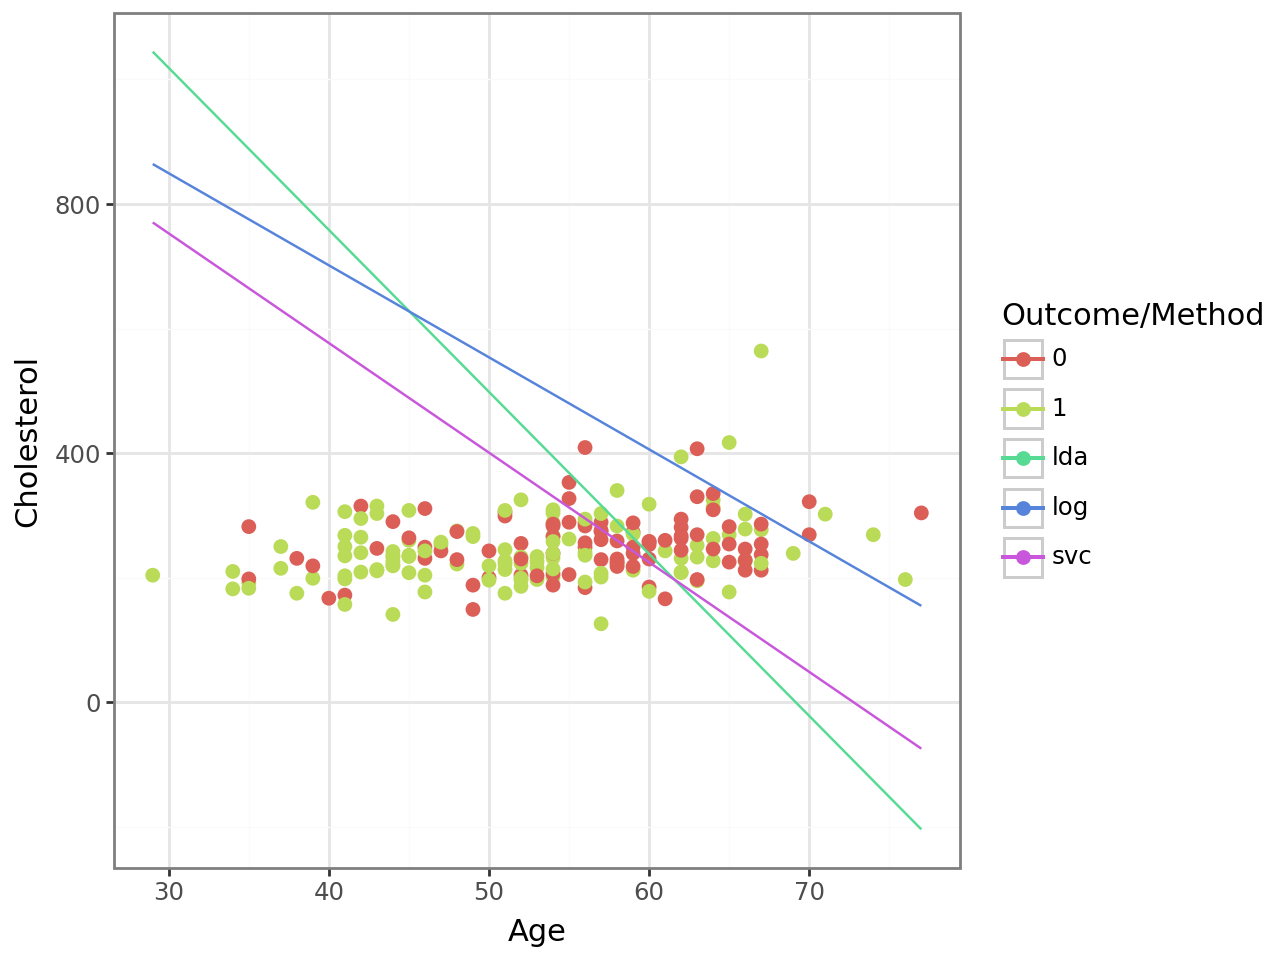

In [127]:
# Create a DataFrame for the boundaries
df_lines = pd.DataFrame({
    'x': np.tile(age_range, 3),  # Repeat age_range for all methods
    'y': np.concatenate([logreg_boundary, lda_boundary, svc_boundary]),
    'method': ['log'] * len(age_range) + ['lda'] * len(age_range) + ['svc'] * len(age_range)
})

# Plot
(ggplot(df, aes(x='age', y='chol', color='diagnosis')) +  # Scatterplot of points
    geom_point(size=2) +
    geom_line(data=df_lines, mapping=aes(x='x', y='y', group='method', color='method')) +  # Decision boundaries
    labs(x='Age', y='Cholesterol', color='Outcome/Method') +
    theme_bw()
)

The scatterplot shows age vs. cholesterol, with points colored by disease outcome (0: no disease, 1: disease). The decision boundaries for Logistic Regression, LDA, and SVC separate the two classes. Logistic Regression (log) and SVC (svc) have similar boundaries, while LDA (lda) has a steeper slope due to its assumptions about class distributions. All models generally separate the classes well, but some overlap exists, indicating potential misclassifications in regions where red and green points are mixed.